In [2]:
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from dotenv import load_dotenv
from src.paths import PARENT_DIR
from matplotlib import pyplot
import pandas as pd
import seaborn as sns
import hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import shutil
import joblib

c:\Users\vivek\Documents\iris\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
HOPSWORKS_PROJECT_NAME = 'Vivekmaj1'

# load key-value pairs from .env file located in the parent directory
load_dotenv(PARENT_DIR / '.env')

HOPSWORKS_API_KEY = os.environ['HOPSWORKS_API_KEY']

project = hopsworks.login(
    project=HOPSWORKS_PROJECT_NAME,
    api_key_value=HOPSWORKS_API_KEY
)

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/552084
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
try: 
    feature_view = fs.get_feature_view(name="iris", version=1)
except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

In [5]:
iris, _ = feature_view.training_data(
    description='Iris Data',
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.57s) 


In [6]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.7,3.8,1.7,0.3
1,5.6,2.7,4.2,1.3
2,6.3,3.3,6.0,2.5
3,6.0,2.9,4.5,1.5
4,5.0,3.0,1.6,0.2


In [7]:
X_train,X_test,y_train,y_test = train_test_split(iris, _, test_size=0.2)

In [8]:
class ExtractExtraFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Create new features
        X['sepal_area'] = X['sepal_length'] * X['sepal_width']
        X['petal_area'] = X['petal_length'] * X['petal_width']
        X['sepal_petal_length_diff'] = X['sepal_length'] - X['petal_length']
        X['sepal_petal_width_diff'] = X['sepal_width'] - X['petal_width']
        X['sepal_length_to_width'] = X['sepal_length'] / X['sepal_width']
        X['petal_length_to_width'] = X['petal_length'] / X['petal_width']
        
        return X

In [9]:
# Create a pipeline
pipeline = Pipeline([
    ('extract_features', ExtractExtraFeatures()),
    ('classifier', KNeighborsClassifier())
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('extract_features', ExtractExtraFeatures()),
                ('classifier', KNeighborsClassifier())])

In [10]:
y_pred = pipeline.predict(X_test)
y_pred

array(['Virginica', 'Setosa', 'Virginica', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Setosa', 'Virginica',
       'Virginica', 'Versicolor', 'Virginica', 'Setosa', 'Versicolor',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Virginica',
       'Versicolor', 'Versicolor', 'Virginica', 'Versicolor'],
      dtype=object)

In [11]:
metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}, 'Versicolor': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 11.0}, 'Virginica': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526315, 'support': 10.0}, 'accuracy': 0.9666666666666667, 'macro avg': {'precision': 0.9722222222222222, 'recall': 0.9666666666666667, 'f1-score': 0.9679633867276888, 'support': 30.0}, 'weighted avg': {'precision': 0.9694444444444444, 'recall': 0.9666666666666667, 'f1-score': 0.9665141113653699, 'support': 30.0}}


In [12]:
results = confusion_matrix(y_test, y_pred)
print(results)

[[ 9  0  0]
 [ 0 11  0]
 [ 0  1  9]]


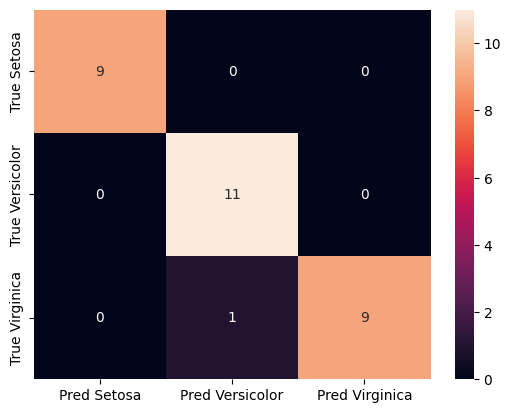

In [13]:
df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("../assets/confusion_matrix.png") 
fig.show()

In [14]:
project = hopsworks.login(
    project=HOPSWORKS_PROJECT_NAME,
    api_key_value=HOPSWORKS_API_KEY
)

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(pipeline, model_dir + "/iris_model.pkl")
shutil.copyfile("../assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_registry = project.get_model_registry()

model = model_registry.python.create_model(
    version=1,
    name="iris_model",
    metrics={"accuracy" : metrics['accuracy'], "recall": metrics['weighted avg']['recall'],
             "precision": metrics['weighted avg']['precision'], "f1": metrics['weighted avg']['f1-score']},
    description="None",
    input_example=X_train.sample(),
    model_schema=model_schema
)

model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/552084
Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 18014/18014 elapsed<00:01 remaining<00:001,  3.64it/s]
Uploading: 100.000%|██████████| 23834/23834 elapsed<00:01 remaining<00:001,  3.64it/s]
Uploading: 100.000%|██████████| 81/81 elapsed<00:01 remaining<00:0003<00:07,  1.86s/it]
Uploading: 100.000%|██████████| 1018/1018 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/552084/models/iris_model/1


Model(name: 'iris_model', version: 1)